In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Activation, Dense,LSTM,Dropout
from sklearn.metrics import mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
import requests
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [3]:
# Database related all the code is moved to this file
%run -i "SqlConn.py"
#importing local py file
import SqlConn 

In [4]:
#Fetch Tweets and Sentiment data - Join from Tweet and Sentiment tables
try:
    df_dbFinanceData = SqlConn.fetchFinanceData("")
    print("Data transfer Done")
except BaseException as err:
    print(err)

Data transfer Done


In [5]:
df_dbFinanceData

,financeType,date,open,high,low,close,adjustedClose,volume,id
0,tesla,2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500,1
1,tesla,2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500,2
2,tesla,2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000,3
3,tesla,2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000,4
4,tesla,2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500,5
...,...,...,...,...,...,...,...,...,...
6916,doge,2022-07-09,0.069224,0.070009,0.068995,0.069512,0.069512,254272147,6917
6917,doge,2022-07-10,0.069509,0.069509,0.066533,0.067263,0.067263,299810124,6918
6918,doge,2022-07-11,0.067268,0.067268,0.061535,0.061847,0.061847,326125900,6919
6919,doge,2022-07-12,0.061851,0.062861,0.060087,0.060087,0.060087,298462083,6920


In [6]:
doge_price = df_dbFinanceData[df_dbFinanceData["financeType"] == "doge"]

In [7]:
doge_price

,financeType,date,open,high,low,close,adjustedClose,volume,id
5213,doge,2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550,5214
5214,doge,2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520,5215
5215,doge,2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080,5216
5216,doge,2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960,5217
5217,doge,2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270,5218
...,...,...,...,...,...,...,...,...,...
6916,doge,2022-07-09,0.069224,0.070009,0.068995,0.069512,0.069512,254272147,6917
6917,doge,2022-07-10,0.069509,0.069509,0.066533,0.067263,0.067263,299810124,6918
6918,doge,2022-07-11,0.067268,0.067268,0.061535,0.061847,0.061847,326125900,6919
6919,doge,2022-07-12,0.061851,0.062861,0.060087,0.060087,0.060087,298462083,6920


In [8]:
end_date = doge_price['date'].iloc[-1]
end_date

'2022-07-13'

In [9]:
doge_price['date'] = pd.to_datetime(doge_price['date'], format='%Y-%m-%d')

SqlConn.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
doge_price.dtypes

financeType              object
date             datetime64[ns]
open                    float64
high                    float64
low                     float64
close                   float64
adjustedClose           float64
volume                    int64
id                        int64
dtype: object

In [11]:
doge_price.set_index("date",inplace = True)

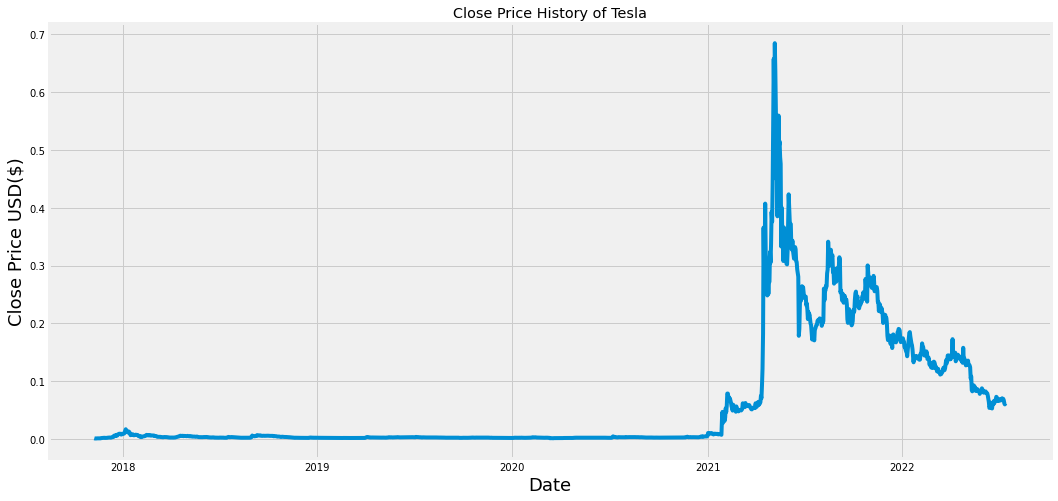

In [12]:
plt.figure(figsize=(16,8))
plt.title('Close Price History of Tesla')
plt.plot(doge_price['close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD($)',fontsize=18)
plt.show()

In [13]:
data = doge_price.drop(['financeType','open', 'high', 'low', 'adjustedClose', 'volume','id'], axis = 1)
price_column = 'close'
data.head()

,close
date,
2017-11-09,0.001415
2017-11-10,0.001163
2017-11-11,0.001201
2017-11-12,0.001038
2017-11-13,0.001211


In [14]:
# This function splits the data in 70,30 ratio.
def train_test_split(df, test_size=0.3):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [15]:
train, test = train_test_split(data, test_size=0.2)

In [16]:
train.shape, test.shape

((1367, 1), (341, 1))

In [17]:
train

,close
date,
2017-11-09,0.001415
2017-11-10,0.001163
2017-11-11,0.001201
2017-11-12,0.001038
2017-11-13,0.001211
...,...
2021-08-02,0.203600
2021-08-03,0.195967
2021-08-04,0.201490


In [18]:
test

,close
date,
2021-08-07,0.260341
2021-08-08,0.240045
2021-08-09,0.256897
2021-08-10,0.257325
2021-08-11,0.265263
...,...
2022-07-09,0.069512
2022-07-10,0.067263
2022-07-11,0.061847


In [19]:
# Perform MinMax scaling
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(data).reshape(-1,1))
df1

array([[0.00055138],
       [0.00018282],
       [0.0002384 ],
       ...,
       [0.08893598],
       [0.0863619 ],
       [0.08909101]])

In [20]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.8)
# test_size=len(df1)-training_size

test_size = 0.2
split_row = len(df1) - int(test_size * len(df1))
# train_data = df.iloc[:split_row]
# test_data = df.iloc[split_row:]
    
train_scaled,test_scaled=df1[0:split_row,:],df1[split_row:,]
training_size,split_row

(1366, 1367)

In [21]:
train_scaled.shape,test_scaled.shape

((1367, 1), (341, 1))

In [22]:
train_scaled

array([[5.51379986e-04],
       [1.82818298e-04],
       [2.38395060e-04],
       ...,
       [2.93170347e-01],
       [2.92415673e-01],
       [2.97847570e-01]])

In [23]:
test_scaled

array([[0.37924266],
       [0.34955882],
       [0.37420565],
       [0.37483162],
       [0.38644132],
       [0.38447858],
       [0.41795188],
       [0.42717323],
       [0.49785518],
       [0.46754244],
       [0.43642969],
       [0.44271425],
       [0.46231969],
       [0.47745265],
       [0.46181218],
       [0.45912987],
       [0.46344585],
       [0.42077606],
       [0.42587596],
       [0.39177376],
       [0.4291038 ],
       [0.41622754],
       [0.40964023],
       [0.39647731],
       [0.4057323 ],
       [0.42905699],
       [0.43132979],
       [0.43179488],
       [0.43635071],
       [0.4584922 ],
       [0.45006501],
       [0.36959425],
       [0.37452156],
       [0.36791524],
       [0.34946668],
       [0.35158737],
       [0.36502086],
       [0.34350534],
       [0.35052995],
       [0.36075023],
       [0.35322981],
       [0.34939063],
       [0.3515201 ],
       [0.33946287],
       [0.30133282],
       [0.29249319],
       [0.32734713],
       [0.327

In [24]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [25]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, ytest = create_dataset(test_scaled, time_step)

In [26]:
print(X_train.shape), print(y_train.shape)

(1266, 100)
(1266,)


(None, None)

In [27]:
print(X_test.shape), print(ytest.shape)

(240, 100)
(240,)


(None, None)

In [28]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [29]:
print(X_train.shape), print(y_train.shape)

(1266, 100, 1)
(1266,)


(None, None)

In [30]:
print(X_test.shape), print(ytest.shape)

(240, 100, 1)
(240,)


(None, None)

In [31]:
X_test

array([[[0.37924266],
        [0.34955882],
        [0.37420565],
        ...,
        [0.37788688],
        [0.38123904],
        [0.38300287]],

       [[0.34955882],
        [0.37420565],
        [0.37483162],
        ...,
        [0.38123904],
        [0.38300287],
        [0.37366744]],

       [[0.37420565],
        [0.37483162],
        [0.38644132],
        ...,
        [0.38300287],
        [0.37366744],
        [0.34546954]],

       ...,

       [[0.20516162],
        [0.20164858],
        [0.21267618],
        ...,
        [0.10176836],
        [0.09977345],
        [0.1001464 ]],

       [[0.20164858],
        [0.21267618],
        [0.21580311],
        ...,
        [0.09977345],
        [0.1001464 ],
        [0.09685713]],

       [[0.21267618],
        [0.21580311],
        [0.25136638],
        ...,
        [0.1001464 ],
        [0.09685713],
        [0.08893598]]])

In [32]:
ytest

array([0.37366744, 0.34546954, 0.34581763, 0.32226478, 0.33941606,
       0.33929028, 0.32949707, 0.31976822, 0.32976618, 0.32291123,
       0.31486869, 0.29228843, 0.29881139, 0.3019193 , 0.31318529,
       0.31251252, 0.30486633, 0.30521588, 0.29098092, 0.26006268,
       0.24895026, 0.25940015, 0.25706739, 0.26049852, 0.24636009,
       0.23895668, 0.24568   , 0.24695534, 0.228928  , 0.26196985,
       0.2633227 , 0.2521664 , 0.24566684, 0.25062487, 0.24649464,
       0.24319806, 0.24883325, 0.25181539, 0.26830706, 0.27142521,
       0.27732658, 0.27639494, 0.27300915, 0.25313607, 0.24384597,
       0.24903509, 0.24784018, 0.25155359, 0.25355435, 0.24724347,
       0.24536409, 0.23164102, 0.23280082, 0.2252102 , 0.22072165,
       0.21942145, 0.20815106, 0.22283503, 0.23490542, 0.25010274,
       0.2669308 , 0.2692036 , 0.25760999, 0.24878938, 0.24051136,
       0.23593506, 0.22547493, 0.20709949, 0.19284259, 0.20596309,
       0.20001784, 0.20769767, 0.20877996, 0.20506217, 0.20566

In [33]:
np.random.seed(42)
tf.random.set_seed(42)
window_len = 100
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 100
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'
activ_func = "relu"

In [34]:
# model = Sequential()
# model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(dropout))
# model.add(Dense(units=1))
# model.add(Activation(activ_func))
# model.compile(loss=loss, optimizer=optimizer)
# model.summary()

In [35]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [36]:
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/100
40/40 [==============================] - 15s 128ms/step - loss: 0.0038
Epoch 2/100
40/40 [==============================] - 5s 135ms/step - loss: 0.0024
Epoch 3/100
40/40 [==============================] - 5s 122ms/step - loss: 0.0019
Epoch 4/100
40/40 [==============================] - 6s 138ms/step - loss: 0.0017
Epoch 5/100
40/40 [==============================] - 5s 120ms/step - loss: 0.0017
Epoch 6/100
40/40 [==============================] - 5s 119ms/step - loss: 0.0016
Epoch 7/100
40/40 [==============================] - 5s 119ms/step - loss: 0.0014
Epoch 8/100
40/40 [==============================] - 5s 121ms/step - loss: 0.0013
Epoch 9/100
40/40 [==============================] - 6s 138ms/step - loss: 0.0012
Epoch 10/100
40/40 [==============================] - 5s 130ms/step - loss: 0.0013
Epoch 11/100
40/40 [==============================] - 5s 129ms/step - loss: 0.0010
Epoch 12/100
40/40 [==============================] - 5s 126ms/step - loss: 0.0011
Epoch 13/100

40/40 [==============================] - 5s 119ms/step - loss: 3.2552e-04
Epoch 96/100
40/40 [==============================] - 5s 124ms/step - loss: 3.8317e-04
Epoch 97/100
40/40 [==============================] - 5s 120ms/step - loss: 3.9358e-04
Epoch 98/100
40/40 [==============================] - 5s 118ms/step - loss: 3.0051e-04
Epoch 99/100
40/40 [==============================] - 5s 119ms/step - loss: 2.9347e-04
Epoch 100/100
40/40 [==============================] - 5s 117ms/step - loss: 2.6787e-04


In [37]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

8/8 [==============================] - 0s 45ms/step


In [38]:
test_predict

array([[0.39517537],
       [0.3957831 ],
       [0.38048348],
       [0.36432457],
       [0.34652534],
       [0.34329078],
       [0.348814  ],
       [0.35072076],
       [0.34403935],
       [0.33896068],
       [0.3338422 ],
       [0.32721484],
       [0.31331897],
       [0.3045763 ],
       [0.30386648],
       [0.31148645],
       [0.31815878],
       [0.3160536 ],
       [0.30910254],
       [0.29655656],
       [0.27429265],
       [0.25311205],
       [0.24694218],
       [0.25032386],
       [0.25709555],
       [0.25494102],
       [0.24438806],
       [0.23675826],
       [0.23534612],
       [0.23075756],
       [0.24038385],
       [0.2549375 ],
       [0.26004997],
       [0.25428018],
       [0.2480212 ],
       [0.24388668],
       [0.24209662],
       [0.24512506],
       [0.2508147 ],
       [0.26210216],
       [0.2723746 ],
       [0.27926874],
       [0.28067207],
       [0.2774821 ],
       [0.26590335],
       [0.252554  ],
       [0.24822971],
       [0.251

In [39]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.016140599397660948

In [40]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

0.016292693597420218

In [41]:
# Calculate the Mean Absolute Error
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(ytest,test_predict)
mae

0.012702571644052687

In [42]:
# Calculate Mean Absolute error using Sklearn library
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(ytest,test_predict)

0.06811788128171062

In [43]:
# Manual calculation of Mean Absolute Percentage error.
total = 0
for i,j in zip(ytest, test_predict):
    value = abs(i-j)/abs(i)
    total+= value
#     print(total)
error = float(total*100/(len(ytest))) # Calculate MAPE
mape = round(error,2) # round to 3 significant figures
print(mape)

6.81


In [44]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [45]:
test_predict

array([[0.2712348 ],
       [0.27165034],
       [0.2611894 ],
       [0.25014094],
       [0.23797089],
       [0.2357593 ],
       [0.23953575],
       [0.24083947],
       [0.23627113],
       [0.23279864],
       [0.22929893],
       [0.22476755],
       [0.2152664 ],
       [0.2092887 ],
       [0.20880337],
       [0.21401344],
       [0.21857557],
       [0.21713617],
       [0.21238346],
       [0.2038053 ],
       [0.18858258],
       [0.17410058],
       [0.169882  ],
       [0.1721942 ],
       [0.17682426],
       [0.17535111],
       [0.16813566],
       [0.16291887],
       [0.16195333],
       [0.15881595],
       [0.16539782],
       [0.17534871],
       [0.17884432],
       [0.17489928],
       [0.17061977],
       [0.16779284],
       [0.1665689 ],
       [0.16863957],
       [0.1725298 ],
       [0.18024747],
       [0.18727115],
       [0.19198494],
       [0.19294445],
       [0.19076334],
       [0.1828465 ],
       [0.17371902],
       [0.17076235],
       [0.173

In [46]:
test_predict.shape

(240, 1)

In [47]:
targets = test[price_column][window_len+1:]
targets

date
2021-11-16    0.237249
2021-11-17    0.237487
2021-11-18    0.221383
2021-11-19    0.233110
2021-11-20    0.233024
                ...   
2022-07-09    0.069512
2022-07-10    0.067263
2022-07-11    0.061847
2022-07-12    0.060087
2022-07-13    0.061953
Name: close, Length: 240, dtype: float64

In [48]:
preds = pd.Series(index=targets.index, data=test_predict.squeeze())
preds

date
2021-11-16    0.271235
2021-11-17    0.271650
2021-11-18    0.261189
2021-11-19    0.250141
2021-11-20    0.237971
                ...   
2022-07-09    0.069663
2022-07-10    0.069829
2022-07-11    0.069921
2022-07-12    0.069172
2022-07-13    0.066201
Length: 240, dtype: float32

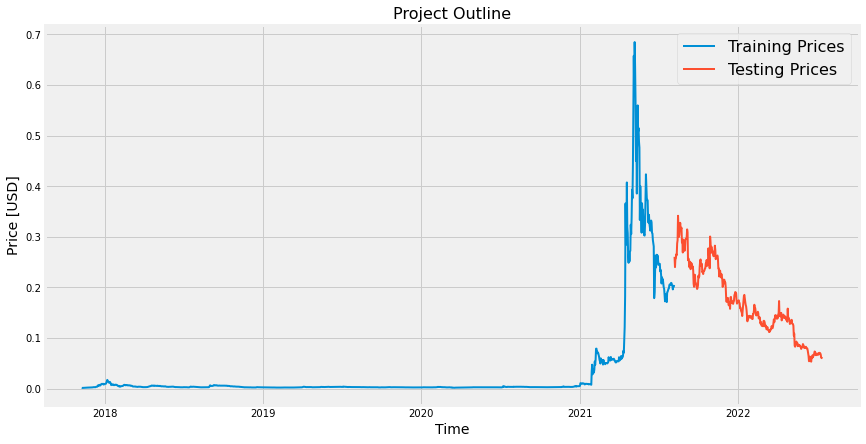

In [49]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('Price [USD]', fontsize=14)
    ax.set_xlabel('Time', fontsize = 14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
line_plot(train["close"], test["close"], 'Training Prices', 'Testing Prices', title='Project Outline')

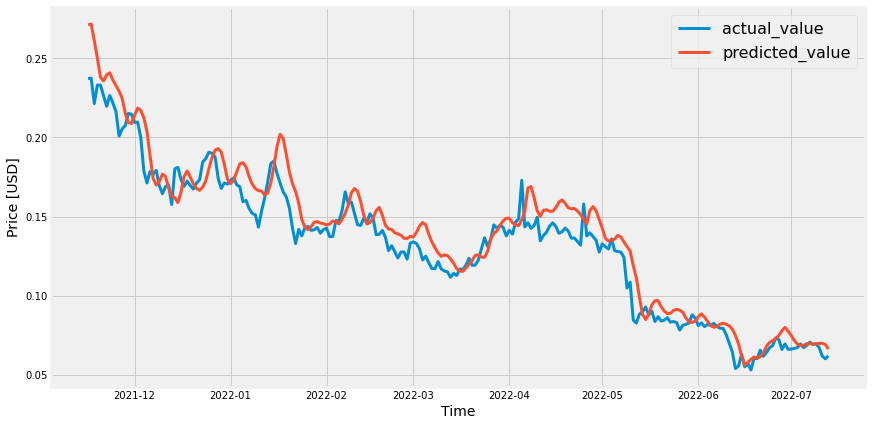

In [50]:
line_plot(targets, preds, 'actual_value', 'predicted_value', lw=3)

### Future Prediction for 30 days

In [51]:
len(test)

341

In [52]:
length = len(test_scaled)
length

341

In [53]:
#Getting the last 100 days records
fut_inp = test_scaled[length-100:]
fut_inp.shape

(100, 1)

In [54]:
fut_inp = fut_inp.reshape(1,-1)

In [55]:
fut_inp.shape

(1, 100)

In [56]:
fut_inp

array([[0.25136638, 0.20823589, 0.21216283, 0.2069664 , 0.20953171,
        0.21718375, 0.1954196 , 0.20042443, 0.20335537, 0.20897155,
        0.21205167, 0.20866734, 0.20244713, 0.20365666, 0.20713606,
        0.20452249, 0.19792201, 0.19796589, 0.19481557, 0.19146048,
        0.22950424, 0.1999725 , 0.20279961, 0.19938164, 0.19596513,
        0.18503991, 0.19266855, 0.18998477, 0.18791088, 0.19710884,
        0.18631671, 0.18554302, 0.18500334, 0.18014038, 0.15179184,
        0.15713452, 0.12218551, 0.11939205, 0.12767006, 0.12981269,
        0.13426907, 0.12695341, 0.13042257, 0.12082242, 0.12531829,
        0.12130213, 0.12201293, 0.12441443, 0.12024325, 0.12080487,
        0.11985129, 0.11292906, 0.11743809, 0.11817521, 0.11941399,
        0.12699729, 0.12406342, 0.11703004, 0.11953977, 0.11613203,
        0.11808453, 0.11728306, 0.11918583, 0.11623587, 0.1146651 ,
        0.11451446, 0.10883685, 0.10070656, 0.09257626, 0.07734384,
        0.07978776, 0.0906223 , 0.07896434, 0.08

In [57]:
tmp_inp = list(fut_inp)

In [58]:
tmp_inp

[array([0.25136638, 0.20823589, 0.21216283, 0.2069664 , 0.20953171,
        0.21718375, 0.1954196 , 0.20042443, 0.20335537, 0.20897155,
        0.21205167, 0.20866734, 0.20244713, 0.20365666, 0.20713606,
        0.20452249, 0.19792201, 0.19796589, 0.19481557, 0.19146048,
        0.22950424, 0.1999725 , 0.20279961, 0.19938164, 0.19596513,
        0.18503991, 0.19266855, 0.18998477, 0.18791088, 0.19710884,
        0.18631671, 0.18554302, 0.18500334, 0.18014038, 0.15179184,
        0.15713452, 0.12218551, 0.11939205, 0.12767006, 0.12981269,
        0.13426907, 0.12695341, 0.13042257, 0.12082242, 0.12531829,
        0.12130213, 0.12201293, 0.12441443, 0.12024325, 0.12080487,
        0.11985129, 0.11292906, 0.11743809, 0.11817521, 0.11941399,
        0.12699729, 0.12406342, 0.11703004, 0.11953977, 0.11613203,
        0.11808453, 0.11728306, 0.11918583, 0.11623587, 0.1146651 ,
        0.11451446, 0.10883685, 0.10070656, 0.09257626, 0.07734384,
        0.07978776, 0.0906223 , 0.07896434, 0.08

In [59]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [60]:
tmp_inp

[0.2513663839564512,
 0.20823589118069905,
 0.21216282821368976,
 0.20696640092198926,
 0.20953170727426693,
 0.21718374993966996,
 0.1954195972439776,
 0.20042443095976684,
 0.20335537390729505,
 0.20897155201034312,
 0.21205167468873357,
 0.2086673423630947,
 0.20244713260469274,
 0.20365665846178146,
 0.20713605630218548,
 0.20452248591933472,
 0.19792201410187218,
 0.19796589049330227,
 0.19481556558862373,
 0.1914604841906049,
 0.22950424065323172,
 0.19997250412803716,
 0.20279960628251423,
 0.19938163539011233,
 0.19596512704409141,
 0.18503990557800565,
 0.19266854750131265,
 0.18998477489217377,
 0.18791088412391277,
 0.19710883831403506,
 0.18631670856862048,
 0.18554302153307037,
 0.1850033419184806,
 0.18014037520164858,
 0.15179183869868473,
 0.15713452062848543,
 0.12218551230805907,
 0.11939204872034505,
 0.12767006123681698,
 0.12981269168498508,
 0.1342690705078985,
 0.12695341351012596,
 0.13042257352586295,
 0.12082241908096511,
 0.1253182866561656,
 0.12130213429393

In [61]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.08790405094623566], [0.08834324777126312], [0.09022680670022964], [0.09282909333705902], [0.09587164223194122], [0.09927099943161011], [0.10304669290781021], [0.10729184001684189], [0.11203880608081818], [0.11730664223432541], [0.12305194139480591], [0.129182368516922], [0.13557153940200806], [0.14207270741462708], [0.14852988719940186], [0.154809832572937], [0.16082124412059784], [0.16651390492916107], [0.17186985909938812], [0.17692680656909943], [0.181757390499115], [0.18639548122882843], [0.191059410572052], [0.195852130651474], [0.2009580135345459], [0.20656432211399078], [0.21288098394870758], [0.22007012367248535], [0.22833043336868286], [0.2378196120262146]]


In [62]:
end_date

'2022-07-13'

In [63]:
temp = pd.to_datetime(end_date, format='%Y-%m-%d')
temp
end_date_new = temp.strftime('%m/%d/%Y')
end_date_new

'07/13/2022'

In [64]:
preds = scaler.inverse_transform(lst_output)
preds

array([[0.06114143],
       [0.06144172],
       [0.06272959],
       [0.06450887],
       [0.06658918],
       [0.06891345],
       [0.07149504],
       [0.07439762],
       [0.0776433 ],
       [0.08124513],
       [0.08517341],
       [0.08936502],
       [0.09373355],
       [0.09817865],
       [0.10259368],
       [0.10688752],
       [0.11099776],
       [0.11489005],
       [0.11855213],
       [0.12200976],
       [0.12531262],
       [0.12848386],
       [0.13167277],
       [0.13494974],
       [0.13844083],
       [0.14227408],
       [0.14659303],
       [0.15150853],
       [0.15715642],
       [0.16364454]])

In [65]:
import datetime
date_future = temp + datetime.timedelta(41)
date_future_str = date_future.strftime('%m/%d/%Y')
date_future_str

'08/23/2022'

In [66]:
c = pd.date_range(start=end_date_new, end=date_future_str, freq='B')
c

DatetimeIndex(['2022-07-13', '2022-07-14', '2022-07-15', '2022-07-18',
               '2022-07-19', '2022-07-20', '2022-07-21', '2022-07-22',
               '2022-07-25', '2022-07-26', '2022-07-27', '2022-07-28',
               '2022-07-29', '2022-08-01', '2022-08-02', '2022-08-03',
               '2022-08-04', '2022-08-05', '2022-08-08', '2022-08-09',
               '2022-08-10', '2022-08-11', '2022-08-12', '2022-08-15',
               '2022-08-16', '2022-08-17', '2022-08-18', '2022-08-19',
               '2022-08-22', '2022-08-23'],
              dtype='datetime64[ns]', freq='B')

In [67]:
len(c)

30

In [68]:
fut_preds = pd.Series(index=c, data=preds.squeeze())
fut_preds

2022-07-13    0.061141
2022-07-14    0.061442
2022-07-15    0.062730
2022-07-18    0.064509
2022-07-19    0.066589
2022-07-20    0.068913
2022-07-21    0.071495
2022-07-22    0.074398
2022-07-25    0.077643
2022-07-26    0.081245
2022-07-27    0.085173
2022-07-28    0.089365
2022-07-29    0.093734
2022-08-01    0.098179
2022-08-02    0.102594
2022-08-03    0.106888
2022-08-04    0.110998
2022-08-05    0.114890
2022-08-08    0.118552
2022-08-09    0.122010
2022-08-10    0.125313
2022-08-11    0.128484
2022-08-12    0.131673
2022-08-15    0.134950
2022-08-16    0.138441
2022-08-17    0.142274
2022-08-18    0.146593
2022-08-19    0.151509
2022-08-22    0.157156
2022-08-23    0.163645
Freq: B, dtype: float64

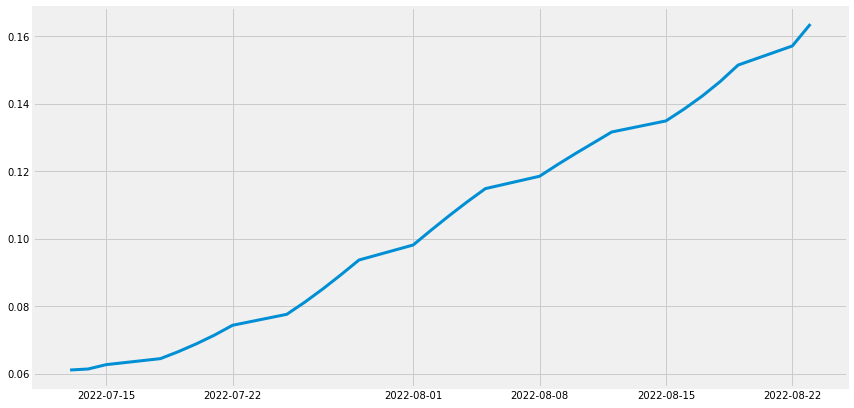

In [69]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(fut_preds, label="predicted value_30", linewidth=3)

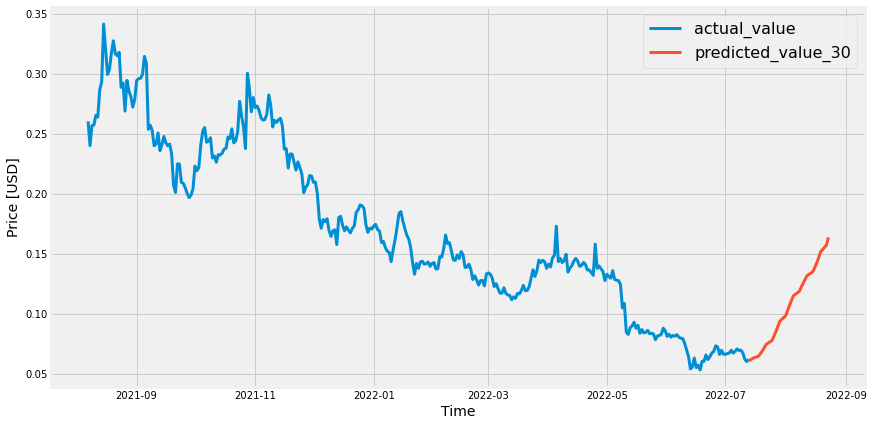

In [70]:
line_plot(test["close"], fut_preds, 'actual_value', 'predicted_value_30', lw=3)